In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Further Testing

In this notebook, we look manually at some of the output from the model at three points in training:

0. After 2 epochs of training on the full training dataset (about 137000 rows, taking about 40 hours on 22GB GPU).
1. After 9 epochs of training on the full training dataset (about 137000 rows, taking about 180 hours on 22GB GPU).
2. After 50 additional epochs of training on a smaller datase (about 20000 rows, taking about 11 hours on 22GB GPU).

The bleu and chr f-score metrics for these models were similar in validation, but by looking at the actual output of each of these models we can get a sense for which is giving us closer to what we are looking for.

# Test metrics

For the three models we are considering, let's first revisit their bleu and chr f-score performance, comparing the test sets with the evaluation scores we saw in the modeling notebook. (We also look at epoch 8 in this section.)

In [5]:
with open("eval_metrics.json", "r") as read_file:
    eval_metrics = json.load(read_file)

with open("eval_metrics_short.json", "r") as read_file:
    eval_metrics_short = json.load(read_file)

with open("test_metrics.json", "r") as read_file:
    test_metrics = json.load(read_file)

In [6]:
def extract_data(data, column):
  return pd.Series([entry[column] for entry in data])

In [20]:
columns = ['eval_loss', 'eval_bleu_bleu', 'eval_chr_f_score']

dict_for_df = {col : pd.concat([extract_data(eval_metrics, col), extract_data(test_metrics[:3], col)]).reset_index(drop=True) for col in columns}
dict_for_df['epoch'] = [0] + list(range(2,10)) + [2, 8, 9]
dict_for_df['val_or_test'] = ['val' for _ in range(9)] + ['test', 'test', 'test']
dict_for_df_short = {col : pd.concat([extract_data(eval_metrics_short, col), extract_data(test_metrics[2:], col)]).reset_index(drop=True) for col in columns}
dict_for_df_short['step'] = [i*5000 for i in range(6)] + [0, 25000]
dict_for_df_short['val_or_test'] = ['val' for _ in range(6)] + ['test', 'test']

# dict_for_df
df = pd.DataFrame(dict_for_df)
df_short = pd.DataFrame(dict_for_df_short)

### Full data epochs

First, we look at the graph for the training done on the full dataset.

<Axes: title={'center': 'BLEU scores for first 9 epochs on full dataset'}, xlabel='epoch', ylabel='eval_bleu_bleu'>

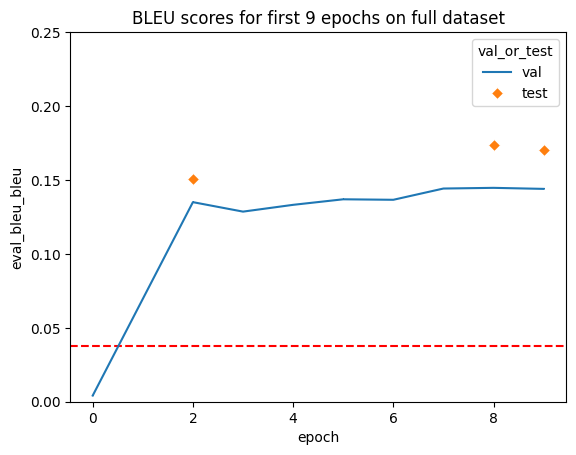

In [41]:
plt.ylim(0,.25)
plt.axhline(y=0.038, color='r', linestyle='--')
plt.title('BLEU scores for first 9 epochs on full dataset')
sns.lineplot(data=df, x='epoch', y='eval_bleu_bleu', hue='val_or_test', style='val_or_test', dashes=["", (0,1)], markers=[',', 'D'])

<Axes: title={'center': 'Chr f-scores for first 9 epochs on full dataset'}, xlabel='epoch', ylabel='eval_chr_f_score'>

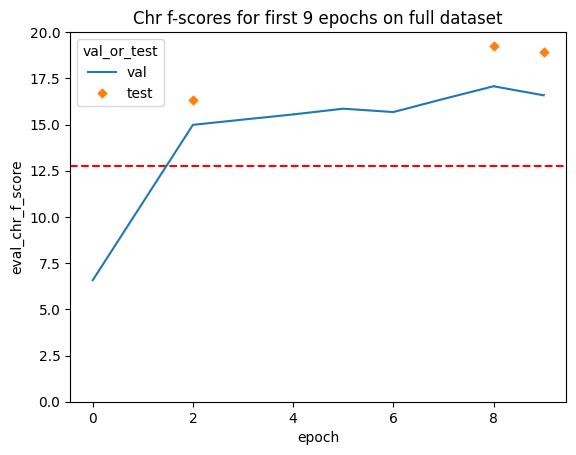

In [42]:
plt.ylim(0,20)
plt.axhline(y=12.78, color='r', linestyle='--')
plt.title('Chr f-scores for first 9 epochs on full dataset')
sns.lineplot(data=df, x='epoch', y='eval_chr_f_score', hue='val_or_test', style='val_or_test', dashes=["", (0,1)], markers=[',', 'D'])

In both metrics, each model actually performs a bit better on the test set. It follows the same general trend though, indicating improvement with further training.

### Shorter dataset epochs

We now compare the test metrics for the training on the shorter data.

<Axes: title={'center': 'BLEU scores for last 50 epochs on shorter dataset'}, xlabel='step', ylabel='eval_bleu_bleu'>

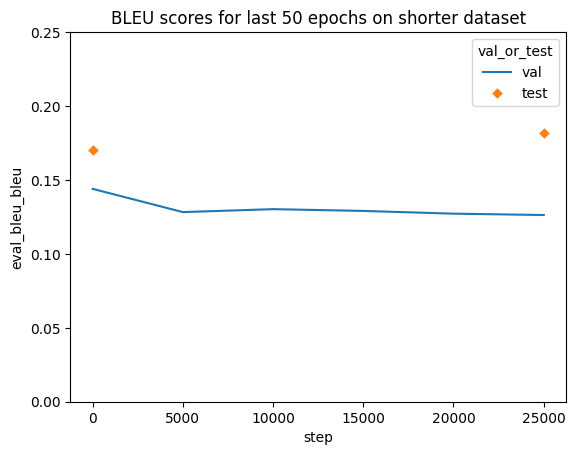

In [43]:
plt.ylim(0,.25)
plt.title('BLEU scores for last 50 epochs on shorter dataset')
sns.lineplot(data=df_short, x='step', y='eval_bleu_bleu', hue='val_or_test', style='val_or_test', dashes=["", (0,1)], markers=[',', 'D'])

<Axes: title={'center': 'Chr f-scores for last 50 epochs on shorter dataset'}, xlabel='step', ylabel='eval_chr_f_score'>

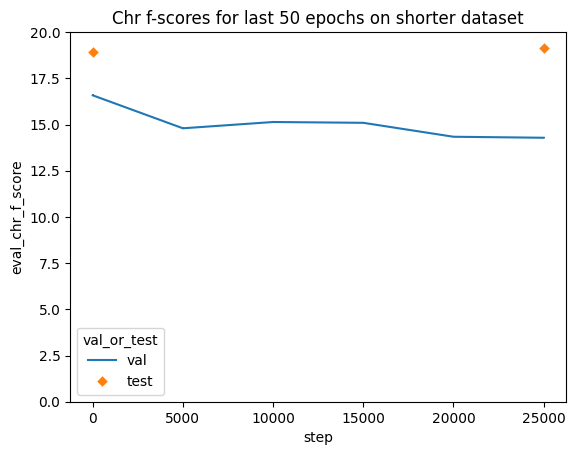

In [44]:
plt.ylim(0,20)
plt.title('Chr f-scores for last 50 epochs on shorter dataset')
sns.lineplot(data=df_short, x='step', y='eval_chr_f_score', hue='val_or_test', style='val_or_test', dashes=["", (0,1)], markers=[',', 'D'])

Instead of the decline we saw in the validation set, we actually see the same or better performance on the test set in this metric. Overall, these scores are all too close to draw and definitive conclusions, and these metrics do not perfectly capture what we would like to see anyway, so we must try to make judgements based on manual inspection of the outputs.

# Loading models and data

We load the three models, indexed 0, 1, and 2, into a list, and load the tokenizer.

In [ ]:
models = [AutoModelForSeq2SeqLM.from_pretrained(
            "/content/drive/MyDrive/Colab Notebooks/epoch" + str(epoch) + "model"
            )
          for epoch in [2,9]] + [AutoModelForSeq2SeqLM.from_pretrained(
            "/content/drive/MyDrive/Colab Notebooks/checkpoints/checkpoint-25000")]
tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean4-tacgen-byt5-small")

Now we load our test data, creating a list which has the actual inputs/outputs for us to compare our models' predictions to.

In [ ]:
def data_from_json(json_data):
  list_of_input_output_dicts = []
  for thm in json_data:
    new_dicts = [{key: tac[key] for key in ['state_before', 'expanded_tactic']} for tac in thm['traced_tactics']]
    list_of_input_output_dicts.extend(new_dicts)
  return list_of_input_output_dicts

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/mytest_simple.json", "r") as read_file:
    test_in_outs = data_from_json(json.load(read_file))

# Predictions

Now we have each of our models produce eight predictions for each input in a random sample of 50 inputs.

In [ ]:
def predict_tactics(model, state):
  tokenized_state = tokenizer(state, return_tensors="pt")
  tactic_candidates_ids = model.generate(
      # tokenized_state.input_ids.cuda(),
      tokenized_state.input_ids,
      max_length=1024,
      num_beams=8,
      length_penalty=0.0,
      do_sample=False,
      num_return_sequences=8,
      early_stopping=False,
  )
  tactic_candidates = tokenizer.batch_decode(
      tactic_candidates_ids, skip_special_tokens=True
  )
  return tactic_candidates

In [ ]:
random.shuffle(test_in_outs)
samples = test_in_outs[:50]

for j, step in enumerate(samples):
  for i, model in enumerate(models):
    step['predictions' + str(i)] = predict_tactics(model, step['state_before'])

Because the previous cell can take a couple of hours to run, we save the results as a json before continuing.

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/sample_predictions.json", "w") as fp:
  json.dump(samples, fp)

# Comparisons

If we have already run the code above, but have restarted the session, we re-load the data from the file created in the last step above.

In [3]:
with open("sample_predictions.json", "r") as read_file:
    samples = json.load(read_file)

Let's closely examine the first sample, first looking at the input ('state_before') and expected output ('expanded_tactic').

In [16]:
print(samples[0]['state_before'])

S : Type u₁
L : Type u₂
D : Type u₃
inst✝⁵ : Category.{v₁, u₁} S
inst✝⁴ : Category.{v₂, u₂} L
inst✝³ : Category.{v₃, u₃} D
ι : S ⥤ L
inst✝² : Full ι
inst✝¹ : Faithful ι
inst✝ : ∀ (X : L), HasLimitsOfShape (StructuredArrow X ι) D
F : S ⥤ D
X : S
⊢ IsIso (limit.π (diagram ι F (ι.obj X)) (StructuredArrow.mk (𝟙 (ι.obj X))))


In [15]:
print(samples[0]['expanded_tactic'])

exact
    <c> (f : X ≅ Y) : IsIso f.hom</c>
      ((<c> (F : J ⥤ C) [HasLimit F] : IsLimit (limit.cone F)</c> _).<c> {s t : Cone F} (P : IsLimit s) (Q : IsLimit t) : s.pt ≅ t.pt</c>
        (<c> {X : J} (tX : IsInitial X) (F : J ⥤ C) :
    IsLimit (coneOfDiagramInitial tX F) where
  lift s</c> <c> [Full T] [Faithful T] : IsInitial (mk (𝟙 (T.obj Y))) where
  desc c</c> _))


And now let's see what our models predict:

In [7]:
samples[0]['predictions0']

['suffices <c> (F : S ⥤ D) [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D] [HasLimitsOfShape (StructuredArrow X ι) D]\n    [HasLimitsOfShape (StructuredArrow 

The 0th model, having just trained 2 epochs, is clearly prone to overly repetitive loops. Although it shows signs of having started to learn from the data, the output is not at all usable. The brief testing done on training/validation sets during training showed similar problems, which is why we opted to continue training.

In [8]:
samples[0]['predictions1']

['suffices <c> (f : X ⟶ Y) : Prop where\n  \n  out : ∃ inv : Y ⟶ X, f ≫ inv = 𝟙 X ∧ inv ≫ f = 𝟙 Y</c> (<c> (X : S) : StructuredArrow X ι</c> X ι) (<c> (X : S) : StructuredArrow X ι</c> X ι)',
 'suffices <c> (f : X ⟶ Y) : Prop where\n  \n  out : ∃ inv : Y ⟶ X, f ≫ inv = 𝟙 X ∧ inv ≫ f = 𝟙 Y</c> (<c> (X : S) : StructuredArrow X ι</c> X ι) (<c> (X : S) : StructuredArrow X ι</c> X ι) from <c> {α : Sort u} {a : α} : Eq a a</c>)',
 'suffices <c> (f : X ⟶ Y) : Prop where\n  \n  out : ∃ inv : Y ⟶ X, f ≫ inv = 𝟙 X ∧ inv ≫ f = 𝟙 Y</c> (<c> (X : S) : StructuredArrow X ι</c> X ι) (<c> (X : S) : StructuredArrow X ι</c> X ι) from <c> {α : Sort u} {a : α} : Eq a a</c>',
 'suffices <c> (f : X ⟶ Y) : Prop where\n  \n  out : ∃ inv : Y ⟶ X, f ≫ inv = 𝟙 X ∧ inv ≫ f = 𝟙 Y</c> (<c> (X : S) : StructuredArrow X ι</c> X ι) (<c> (X : S) : StructuredArrow X ι</c> X ι) (<c> (X : S) : StructuredArrow X ι</c> X ι)',
 'suffices <c> (f : X ⟶ Y) : Prop where\n  \n  out : ∃ inv : Y ⟶ X, f ≫ inv = 𝟙 X ∧ inv ≫ f = 𝟙 Y</c>

The outputs from the model after 9 full epochs are much more reasonable. We still see some repetition, with '(< c> (X : S) : StructuredArrow X ι< /c> X ι)' being repeated 2-4 times in each output. This amount of repetition is not unreasonable, since the same theorem can be referred to multiple times.

In [9]:
samples[0]['predictions2']

['exact <c> {α : Sort u} [i : α] : α</c>',
 'exact <c> {α : Sort u} [i : α] : α</c> (<c> {α : Sort u} [i : α] : α</c> X)',
 'exact <c> {α : Sort u} [i : α] : α</c> (<c> {α : Sort u} [i : α] : α</c> _)',
 'exact <c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso (f ≫ g) ↔ IsIso f</c> (<c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ ',
 'exact <c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso (f ≫ g) ↔ IsIso f</c> (<c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : α.inv ≫ f = g ↔ f = ',
 'exact <c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ IsIso g → IsIso f</c> (<c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ ',
 'exact <c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso (f ≫ g) ↔ IsIso f</c> _ (<c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ ',
 'exact <c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ IsIso f ↔ IsIso g</c> (<c> (α : X ≅ Y) {f : X ⟶ Z} {g : Y ⟶ Z} : IsIso f ↔ ']

These outputs look the best, avoiding repetition while also being the closest in spirit to the actual output. The first guess is too short, however.

# Length of output

Let's do a quick analysis of how well each of our models approximate the length of the output. Of course, this is not a very strong metric for evaluating performance overall, but it is useful to verify if a model is considerably differing from what we would expect.

In [10]:
def my_length(x):
  if type(x) == list:
    return [len(e) for e in x]
  else:
    return len(x)

In [11]:
lengths = [{key : my_length(sample[key]) for key in ['expanded_tactic', 'predictions0', 'predictions1', 'predictions2']} for sample in samples]
content_lengths = [lengths[i] for i, entry in enumerate(samples) if '</c>' in entry['expanded_tactic']]

In [12]:
def calculate_length_error(model_num, lengths):
  diffs = []
  for entry in lengths:
    diffs += [pred_length - entry['expanded_tactic'] for pred_length in entry['predictions' + str(model_num)]]
  sq_diffs = [diff ** 2 for diff in diffs]
  return sum(sq_diffs) / len(sq_diffs)

In [13]:
len(content_lengths)

24

In [14]:
[calculate_length_error(i, content_lengths) for i in range(3)]

[38216.973958333336, 20571.171875, 25466.869791666668]

We see that our model after 2 full epochs is the most off the mark, probably producing text which is too long. After 9 full epochs we get the closest to the actual lengths, while the 50 epochs on the shorter data produces a model which has a tendency to produce shorter-than-expected outputs. However, none of these values is actually concerning enough to discount the model based on this analysis alone. Even the length of the 2-epoch model is not necessarily an issue on its own; its problem is the egregious repetition we saw.

# Conclusion

We saw during the modeling phase that the bleu and chr f-score metrics were similar for all of models 0, 1, and 2, with the best performer being model 1 (after 9 full epochs). Repeating that analysis on the test data, we see that model 1 and model 2 may actually be performing equally in those metrics, still slightly better than model 0. However, after looking at the actual output, we see that model 0's output is in fact considerably worse than 1 and 2 in practice.

While model 2's output looks the best in our limited experimentation, the output of model 1 shows promise as well. Both of those models are at the point where they consistently produce workable guesses, legitimizing their use as either a conjecture-suggesting copilot for human users or as a piece of an automatic theorem proving algorithm. In fact, since their outputs appear to be markedly different, they could work in tandem, providing alternative guesses of a different flavor.

Further fine-tuning would be beneficial, but would rely upon interaction with Lean via LeanDojo or a similar system. Incorporating an automatic Lean interaction framework has turned out to be a technical challenge beyond the scope of this project.